In [1]:
#import Programming Framework for Clinical Image Analysis
#NOTE: The library will create the directory structure for itself.
#The data is needed to be copied into the raw directory
import pfca
import os

Current Working Directory: /Users/shwetankpanwar/Documents/BTPData/python_scripts/cmb_segmentation
The file structure creation failed. Structure already exists!


In [2]:
#DICOM file reading toolkit
from pfca import file_read as f

In [3]:
#For plotting 2D plots
from pfca.visuals.img2D import imgplot

In [4]:
#for preprocessing operations of DICOM-NIFTI conversion and 
#skull stripping
from pfca.core.preprocessing import dcm_to_nifti, skull_stripping

In [5]:
#To import nifti files in ANTS format
from pfca.core.preprocessing import nifti_ANTS

In [6]:
from pfca.core.preprocessing import bias_field_correction

In [7]:
#Function to perform registration of data with MNI T2 template
from pfca.core.preprocessing import mni_template_registration

In [8]:
from pfca.core.processing import rst_3d

In [9]:
#Initializing the raw and nifti path for the data analysis library
#Useful for running all other crucial functions
raw_dir, nifti_dir = pfca.init_path()
cur_path = os.getcwd()

In [10]:
#Not to include in the steps
#Just to show how the raw directory is returned by the function
raw_dir

'/Users/shwetankpanwar/Documents/BTPData/python_scripts/cmb_segmentation/datasets/raw/'

In [11]:
#it returns the list of all the patient folders
patients_dir = f.get_immediate_subdirectories(raw_dir)

In [12]:
#Not to include in the steps
#Just to show how the folders inside the raw directory
patients_dir

['p2']

In [13]:
#choosing the patient folder to be analyzed
patient = patients_dir[0]

In [14]:
#returns the list of all the DICOM files
#Currently, the system works for GE Scanner format
file_list = f.dcm_lst(raw_dir+patient)

In [16]:
#Not to include in the steps
#Just to show how the DICOM files inside the directory
file_list

In [17]:
#Selecting the list of DICOM files of specific format
eswan_list = f.get_label_based_list(file_list,'eSWAN')

#If phase image is also present
#phase_list = f.get_label_based_list(file_list,'FILT_PHA: eSWAN')

In [18]:
#Extracting image array from the DICOM files and stacking them 
#together in correct order
img_eSWAN = f.extract_dcm_array(eswan_list)

Subject Name(For research purposes) :IQUEBAL
Array Dimensions:
(512, 512, 68)


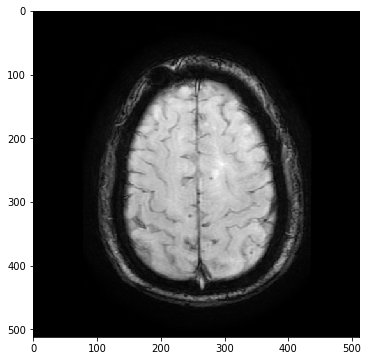

In [19]:
#function to plot the 2D slice from the DICOM data
imgplot(img_eSWAN, slice_no = [55])

In [20]:
#Developing NIFTI file from the DICOM data
#NIFTI file will be stored in the datasets folder
dcm_to_nifti(img_eSWAN,patient, nifti_dir, eswan_list, 
             rotation = True)

p2 nifti file generated successfully with the metadata provided.


In [21]:
#performing skull stripping and saving it as NIFTI file
#NOTE : Add '_conv' suffix after the patient name --> only use for the files converted using dcm_to_nifti()
skull_stripping(nifti_dir,patient+'_conv')

Skull stripping done successfully.
Skull stripped file saved successfully!


In [22]:
#images are needed to be converted into ANTS format for performing preprocessing steps like registration
im_ants_eswan = nifti_ANTS(nifti_dir, patient, category = 'eswan',
                          unskulled = True)

In [23]:
im_ants_eswan

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 68)
	 Spacing    : (0.4492, 0.4492, 2.0)
	 Origin     : (102.228, 120.526, -28.8181)
	 Direction  : [-0.9983  0.0554  0.0197 -0.0568 -0.9955 -0.0762  0.0154 -0.0772  0.9969]

In [25]:
im_corrected = bias_field_correction(im_ants_eswan)

Time taken for N4 bias field correction:  39.735857009887695


In [26]:
im_MNI = mni_template_registration(cur_path, im_corrected, patient)

In [27]:
#Converting registered image to numpy format
im_array = im_MNI.numpy()

In [28]:
#Running Radial Symmetry Transform on the data
rst_results = rst_3d(im_array,2,2,0.2)

Time taken for 3D RST: 20.676609992980957


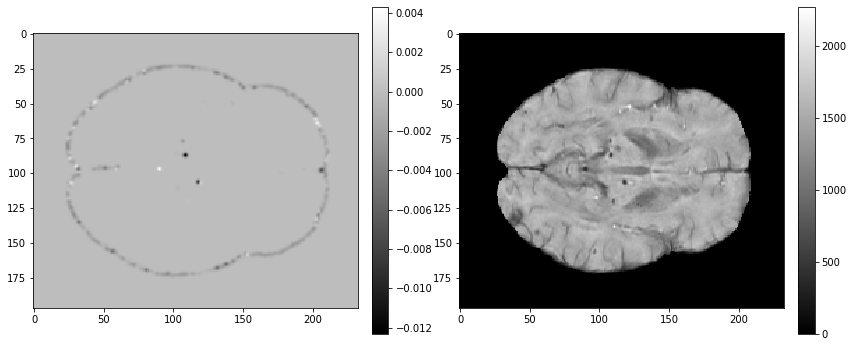

In [29]:
imgplot(rst_results, im_array, slice_no = [65,65])

In [11]:
def xyz2orFromMNI(x,y,z,size = 1,coordef = 'xyz'):
    #Written by Michael T Rubens, June 4 2008, UC San Francisco, Gazzaley Lab
    #Arguments:
    #x,y,z = coordinates of the point
    #size = voxel size in mm
    #coordef = type of input xyz variable, ie 'xyz' or 'mni' form
    import numpy as np
    origin = np.array([45,63,36])
    if coordef == 'xyz':
        x1 = (origin[0] - x)*size
        y1 = (origin[1] - y)*size
        z1 = (origin[2] - z)*size 
    elif coordef == 'mni':
        x1 = origin[0] - (x/size)
        y1 = (y/size) + origin[1]
        z1 = (z/size) + origin[2]
    
    return np.array([x,y,z])    